### Библиотеки

In [1]:
from bs4 import BeautifulSoup
import requests
from requests import get
import time
import random
import pandas as pd
from time import sleep
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
import numpy as np
from datetime import datetime
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import TimeoutException
import os
import re
from IPython.display import Image, display

In [3]:
# преобразование видимости датафрейма
pd.set_option('display.max_colwidth', None)

pd.set_option('display.width', 200)

In [6]:
# Теперь сбрасываем эти опции если надо
pd.reset_option('display.width')
pd.reset_option('display.max_colwidth')


### Динамический парсинг авито

#### Код

In [30]:
# Константы для парсинга
URL_TEMPLATE = 'https://www.avito.ru/all/avtomobili?p='
PAUSE_DURATION_SECONDS = 1
PAUSE_DURATION_IN_PATH_SECONDS = 0.2
MAX_PAGES = 1  # Количество страниц для парсинга

# ф-ия для парсинга фото
def parse_ad_photo(driver):
    try:
        
       # Ожидание появления <img> с частичным совпадением класса 'desktop'
        photo_update_tag = WebDriverWait(driver, 5).until(
            EC.presence_of_element_located((By.CSS_SELECTOR, "img[class*='desktop']"))
        )
        
        # Извлекаем атрибут 'src'
        photo = photo_update_tag.get_attribute('src').strip() if photo_update_tag else np.nan
    except:
        photo = np.nan
    
    return photo

# ф-ия для парсинга остальных данных
def parse_page(driver, soup):
    # Используем частичное совпадение для поиска блока объявления
    car_blocks = soup.find_all('div', class_=lambda x: x and 'iva-item-root' in x)

    # Инициализация списков для хранения данных
    names, prices, photos, descriptions, cities = [], [], [], [], []
    ad_ids, ad_descriptions, time_updates, parsing_times, ad_paths = [], [], [], [], []

    for car in car_blocks:
        # Текущее время парсинга
        current_time = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        parsing_times.append(current_time)
        
        # Парсинг названия
        try:
            name_tag = car.find('a', class_=lambda x: x and 'styles-module-root' in x)
            name = name_tag['title'].strip() if name_tag and 'title' in name_tag.attrs else np.nan
        except:
            name = np.nan

        # Парсинг цены
        try:
            price_tag = car.find('meta', {"itemprop": "price"})
            price = price_tag['content'] if price_tag and 'content' in price_tag.attrs else np.nan
        except:
            price = np.nan

        # Парсинг описания
        try:
            description_tag = car.find('p', {"data-marker": "item-specific-params"})
            description = description_tag.text.strip() if description_tag else np.nan
        except:
            description = np.nan

        # Парсинг города и автодилера
        try:
            city_tags = car.find_all('span', class_=lambda x: x and 'styles-module-noAccent' in x)
            city = ', '.join([tag.text.strip() for tag in city_tags]) if city_tags else np.nan
        except:
            city = np.nan

        # Парсинг ad_id
        try:
            ad_id = car['data-item-id']  # Извлекаем ad_id из атрибута data-item-id
        except:
            ad_id = np.nan

        # Парсинг ad_description
        try:
            ad_description_tag = car.find('meta', {"itemprop": "description"})
            ad_description = ad_description_tag['content'].strip().replace('\n', '') if ad_description_tag and 'content' in ad_description_tag.attrs else np.nan
        except:
            ad_description = np.nan

        # Парсинг ссылки объявления
        try:
            ad_path_tag = car.find('a', class_=lambda x: x and 'styles-module-root' in x)
            ad_path = 'https://www.avito.ru' + ad_path_tag['href'].strip() if ad_path_tag and 'href' in ad_path_tag.attrs else np.nan
        except:
            ad_path = np.nan

         # Парсинг времени поднятия
        try:
            # Ищем div с частичным совпадением класса 'iva-item-dateInfoStep'
            time_update_div = car.find('div', class_=lambda x: x and 'iva-item-dateInfoStep' in x)
            
            # Проверяем, что div найден, и ищем внутри него тег <p> с атрибутом data-marker="item-date"
            if time_update_div:
                time_update_tag = time_update_div.find('p', {"data-marker": "item-date"})
                time_update_full_text = time_update_tag.text.strip() if time_update_tag else np.nan
                
            else:
                time_update_full_text = "Несколько секунд назад"
        
            # Разделяем текст на слова и берём первые два слова для формирования времени поднятия
            time_update_words = time_update_full_text.split()
            time_update = ' '.join(time_update_words[:2]) if len(time_update_words) >= 2 else time_update_full_text
        except:
            time_update = np.nan


        # Переход по ссылке объявления и парсинг фото
        if ad_path:
            driver.get(ad_path)
            sleep(PAUSE_DURATION_IN_PATH_SECONDS)
            photo = parse_ad_photo(driver)
        else:
            photo = np.nan
                            
        # Добавляем данные в списки
        names.append(name)
        prices.append(price)
        photos.append(photo)
        descriptions.append(description)
        cities.append(city)
        ad_ids.append(ad_id)
        ad_descriptions.append(ad_description)
        time_updates.append(time_update)
        ad_paths.append(ad_path)

    # Возвращаем DataFrame из спарсенных данных
    df_page = pd.DataFrame({
        'name': names,
        'price': prices,
        'photo': photos,
        'description': descriptions,
        'city': cities,
        'ad_id': ad_ids,
        'ad_description': ad_descriptions,
        'time_update': time_updates,
        'parsing_time': parsing_times,
        'ad_path': ad_paths
    })

    return df_page



def main():
    all_cars_df = pd.DataFrame()

    # Проверяем, существует ли файл с уже спарсенными данными
    if os.path.exists('cars_data.csv'):
        all_cars_df = pd.read_csv('cars_data.csv')

    for page_num in range(1, MAX_PAGES + 1):
        print(f"Парсим страницу {page_num}...")

        try:
            url = URL_TEMPLATE + str(page_num)
            driver.get(url)
            sleep(PAUSE_DURATION_SECONDS)

            # Получаем HTML-код страницы
            page_source = driver.page_source

            # Парсим HTML с BeautifulSoup
            soup = BeautifulSoup(page_source, 'html.parser')

            # Парсим данные на текущей странице и добавляем их в DataFrame
            df_page = parse_page(driver, soup)
            all_cars_df = pd.concat([all_cars_df, df_page], ignore_index=True)
            

            # Сохраняем промежуточный результат после каждой страницы
            all_cars_df.to_csv('cars_data.csv', index=False, encoding='utf-8-sig')

        except TimeoutException:
            print(f"Ошибка: страница {page_num} не загрузилась, пропускаем...")
            continue
        except Exception as e:
            print(f"Произошла ошибка на странице {page_num}: {e}")
            continue

    print("Парсинг завершен.")
    
    all_cars_df['ad_id'] = all_cars_df['ad_id'].astype('int64')
    # Сохраняем итоговый DataFrame
    all_cars_df.to_csv('cars_data.csv', index=False, encoding='utf-8-sig')


if __name__ == '__main__':
    try:
        service = Service(executable_path=ChromeDriverManager().install())
        driver = webdriver.Chrome(service=service)
        main()
    except Exception as e:
        print(e)
    finally:
        driver.quit()


Парсим страницу 1...
Парсинг завершен.


#### Презентаия 

**Описание задачи**: разработал скрипт для динамического парсинга в Python для извлечении информации объявлений машин с переходом по ссылке объявления. На скриншоте, ниже можно увидеть в каком виде были объявления на странице и что парсили : заголовок объявления, цена, ссылка фото, описание автомобиля, город продажи авто, ID объявления, описание объявления, время обновления, ссылка на объявление, время парсинга. Было спарсено более 100 000 объявлений. Уникальных из них более 40 000. Под скриншотом можно увидеть как это объявление выглядит в датафрейме.

**Технические детали**: использовались библиотеки Python ( BeautifulSoup, requests, Selenium для динамического парсинга, Pandas для работы с данными).


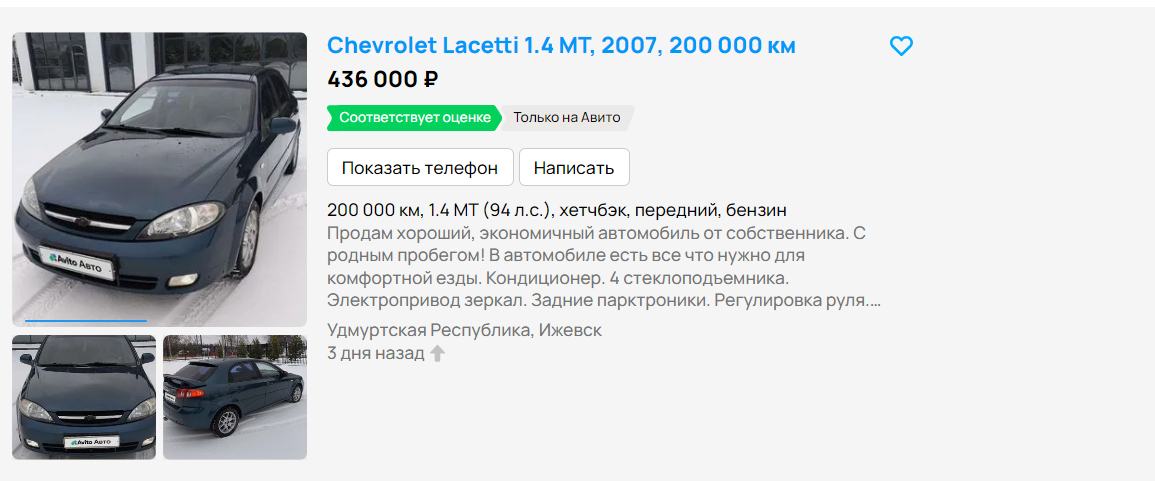

In [36]:
# Отображение изображения
display(Image(filename='Авито_1_1.png', width=1000, height=1000))

In [35]:
df_cars.iloc[[101405]]

,name,price,photo,description,city,ad_id,ad_description,time_update,parsing_time,ad_path
101405,"Chevrolet Lacetti 1.4 MT, 2007, 200 000 км, с пробегом, цена 436 000 руб. - Автомобили в Ижевске",436000.0,https://10.img.avito.st/image/1/1.4yBvNra4T8lZn43MJVHyYXCXTc_Rl83BGZJNy9-fR8PZ.pBThyiE2D3Lnjzor00IHUjxpH5qWJFBsgVCrrJeLb7g,"200 000 км, 1.4 MT (94 л.с.), хетчбэк, передний, бензин","Удмуртская Республика, Ижевск",4455319995,"Продам хороший, экономичный автомобиль от собственника.С родным пробегом!В автомобиле есть все что нужно для комфортной езды.Кондиционер.4 стеклоподъемника.Электропривод зеркал.Задние парктроники.Регулировка руля.Сигнализация с автозапуском.И м",3 дня,2024-11-19 15:02:55,https://www.avito.ru/izhevsk/avtomobili/chevrolet_lacetti_1.4_mt_2007_200_000_km_4455319995


### Чистка данных

#### Код

In [38]:
# Загрузка данных из CSV файла 'cars_data.csv' в DataFrame
df_cars_clear = pd.read_csv('cars_data.csv')

# Сортировка данных по столбцу 'parsing_time' в порядке убывания и удаление дубликатов по 'ad_id', сохраняя последние записи
df_cars_clear = df_cars_clear.sort_values('parsing_time', ascending=False).drop_duplicates('ad_id')

# Удаление строк, где есть пропуски в колонках 'name' и 'description'
df_cars_clear = df_cars_clear.dropna(subset=['name', 'description'])

# Преобразование столбца 'ad_id' в тип данных 'int64'
df_cars_clear['ad_id'] = df_cars_clear['ad_id'].astype('int64')

# Определение, является ли объявление от автодилера, по наличию 'Автодилер' в начале значения столбца 'city'
df_cars_clear['is_dealer'] = df_cars_clear['city'].str.startswith('Автодилер', na=False)

# Преобразование столбца 'parsing_time' в тип данных datetime для удобства работы с датой и временем
df_cars_clear['parsing_time'] = pd.to_datetime(df_cars_clear['parsing_time'])


In [39]:
# Разбиение колоники name

def name_splitting(name):
    try:
        parts = name.split(', ')
        
        if name.startswith('ВАЗ'):
            model = ' '.join(parts[0].split(' ')[:3])
            year = parts[1]
        
        
        else:
            model = ' '.join(parts[0].split(' ')[:2])
            year = parts[1]
        
        return pd.Series([model, year])
    except IndexError:
        return pd.Series([None, None])


# Разбиение колоники description 
def description_splitting(description):
    try:
        if pd.isna(description):
            return pd.Series([None] * 7)
            
        parts_description = description.split(', ')
        
        if description.startswith('Битый'):
            engine = parts_description[2].split(' ')[0]
            transmission = parts_description[2].split(' ')[1]
            power_horse = parts_description[2].split(' ')[2].strip('()').split('л')[0]
            mileage = parts_description[1].replace('км', '').replace(' ', '')
            car_body = parts_description[3]
            wheel_drive = parts_description[4]
            fuel_type = parts_description[5]

        elif len(parts_description) == 4:
        
            engine = parts_description[0].split(' ')[0]           
            transmission = parts_description[0].split(' ')[1]     
            power_horse = parts_description[0].split(' ')[2].strip('()').split('л')[0]
            mileage = '0'                                     
            car_body = parts_description[1]                       
            wheel_drive = parts_description[2]                    
            fuel_type = parts_description[3]  

        elif parts_description[4] == 'электро':
            
            engine = None           
            transmission = parts_description[1].split(' ')[0]     
            power_horse = parts_description[1].split(' ')[1].strip('()').split('л')[0]  
            mileage = parts_description[0].replace('км', '').replace(' ', '')                                   
            car_body = parts_description[2]                       
            wheel_drive = parts_description[3]                    
            fuel_type = parts_description[4]  

    
        
        else:
            engine = parts_description[1].split(' ')[0]
            transmission = parts_description[1].split(' ')[1]
            power_horse = parts_description[1].split(' ')[2].strip('()').split('л')[0]
            mileage = parts_description[0].replace('км', '').replace(' ', '')
            car_body = parts_description[2]
            wheel_drive = parts_description[3]
            fuel_type = parts_description[4]
        return pd.Series([engine, transmission, mileage, power_horse, car_body, wheel_drive, fuel_type])
    except IndexError:
        return pd.Series([None] * 7)


# Функция для преобразования строки во временной интервал
def convert_to_timedelta(time_str):
     # Проверяем, является ли time_str значением NaN
    if pd.isna(time_str):
        return np.nan

    # Проверка на "Несколько секунд"
    if time_str == "Несколько секунд":
        return pd.Timedelta(seconds=2)
        
    # Используем регулярные выражения для извлечения числового значения и временной единицы
    match = re.match(r'(\d+)\s*(минуту|минуты|минут|секунд|часов|часа|час|дней|день|дня|неделю|недели)', time_str)
    if match:
        value, unit = match.groups()
        value = int(value)
        
        # Преобразуем в timedelta на основе единицы времени
        if unit in ['минуту', 'минуты', 'минут']:
            return pd.Timedelta(minutes=value)
        elif unit == 'секунд':
            return pd.Timedelta(seconds=value)
        elif unit in ['часов', 'часа', 'час']:
            return pd.Timedelta(hours=value)
        elif unit in ['дней', 'день', 'дня']:
            return pd.Timedelta(days=value)
        elif unit in ['неделю', 'недели']:
            return pd.Timedelta(weeks=value)
    return pd.NaT  # Возвращаем NaT, если строка не соответствует формату - (минуту|минуты|минут|секунд|часов|часа|час|дней|день|дня|неделю|недели)


In [40]:
# Разделение столбца 'name' на 'model' и 'year' с использованием функции name_splitting
df_cars_clear[['model', 'year']] = df_cars_clear['name'].apply(name_splitting)

# Разделение столбца 'description' на отдельные характеристики автомобиля с использованием функции description_splitting
df_cars_clear[['engine', 'transmission', 'mileage', 'power_horse', 'car_body', 'wheel_drive', 'fuel_type']] = df_cars_clear['description'].apply(description_splitting)

# Преобразование строки 'time_update' во временной интервал
df_cars_clear['time_delta'] = df_cars_clear['time_update'].apply(convert_to_timedelta)

# Удаление неразрывных пробелов в mileage и преобразование в числовой тип
df_cars_clear['mileage'] = df_cars_clear['mileage'].str.replace('\xa0', '').astype('int64')

# Преобразование других столбцов
df_cars_clear = df_cars_clear.astype({
    'year': 'int32',
    'power_horse': 'int32',
    'engine': 'float32'
})

# Вычисление даты обновления объявления на основе времени парсинга и временного интервала
df_cars_clear['date_update'] = df_cars_clear['parsing_time'] - df_cars_clear['time_delta']

# Сброс индекса в DataFrame перед сохранением
df_cars_clear = df_cars_clear.reset_index(drop=True)

# Сохранение очищенных данных в CSV файл
df_cars_clear.to_csv('cars_data_clear.csv', index=False)



In [ ]:
df_cars_clear.sort_values('parsing_time', ascending = False).head()

#### Презентация

**Очистка и обработка данных:** создал несколько функций для извлечения нужной информации из колонок с текстом заголовка объявления , описания авто, для преобразования времени обновления объявления,   и дальнейшего распределения данных по колонкам датафрейма. Например таких как , модель авто, год выпуска, город продажи и др., можно увидеть ниже. А также удалил дубликаты , оставив последние спарсенные объявления, преобразовал на правильные и удобные типы данных. 

In [45]:
# Колонки, с которыми работал
df_cars.iloc[[101405]]

,name,price,photo,description,city,ad_id,ad_description,time_update,parsing_time,ad_path
101405,"Chevrolet Lacetti 1.4 MT, 2007, 200 000 км, с пробегом, цена 436 000 руб. - Автомобили в Ижевске",436000.0,https://10.img.avito.st/image/1/1.4yBvNra4T8lZn43MJVHyYXCXTc_Rl83BGZJNy9-fR8PZ.pBThyiE2D3Lnjzor00IHUjxpH5qWJFBsgVCrrJeLb7g,"200 000 км, 1.4 MT (94 л.с.), хетчбэк, передний, бензин","Удмуртская Республика, Ижевск",4455319995,"Продам хороший, экономичный автомобиль от собственника.С родным пробегом!В автомобиле есть все что нужно для комфортной езды.Кондиционер.4 стеклоподъемника.Электропривод зеркал.Задние парктроники.Регулировка руля.Сигнализация с автозапуском.И м",3 дня,2024-11-19 15:02:55,https://www.avito.ru/izhevsk/avtomobili/chevrolet_lacetti_1.4_mt_2007_200_000_km_4455319995


In [55]:
# Колонки извлеченных данных
df_cars_clear[['is_dealer', 'model', 'year', 'engine', 'transmission', 'mileage',
       'power_horse', 'car_body', 'wheel_drive', 'fuel_type', 'time_delta', 'date_update', 'parsing_time']].iloc[[48]]

,is_dealer,model,year,engine,transmission,mileage,power_horse,car_body,wheel_drive,fuel_type,time_delta,date_update,parsing_time
48,False,Chevrolet Lacetti,2007,1.4,MT,200000,94,хетчбэк,передний,бензин,3 days,2024-11-16 15:02:55,2024-11-19 15:02:55


### Сохранение файла в облако гугл драйв

#### Код

In [46]:
import gspread
from oauth2client.service_account import ServiceAccountCredentials
from df2gspread import df2gspread as d2g
from google.oauth2 import service_account
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive

In [47]:

# Путь к JSON-файлу с ключом
path_to_credentials = 'autoinsights-31fc1c0b2945.json'

# Настройка Google Drive API с использованием ServiceAccountCredentials
scope = ['https://www.googleapis.com/auth/drive']
gauth = GoogleAuth()
gauth.credentials = ServiceAccountCredentials.from_json_keyfile_name(path_to_credentials, scope)
drive = GoogleDrive(gauth)


# Идентификатор файла CSV на Google Диске (находится в URL)
table_id  = '1NtrD5PqsaHHN1AY1-7SOiQkRx9c5jSwQGBTBS1KNViI'

# Файл который нужно перезаписать со своей директории
temp_csv = 'cars_data_clear.csv'

# Перезапись его содержимое
file = drive.CreateFile({'id': table_id})
file.SetContentFile(temp_csv)  # путь к  файлу
file.Upload()
print("CSV файл успешно перезаписан на Google Диске.")

CSV файл успешно перезаписан на Google Диске.


#### Презентация

**Выгрузка данных:**
Создал систему для сохранения обработанных данных на Google Drive для того чтобы все участники проекта могли использовать, постоянно обновляющиеся, данные. Использовал Google Drive API. На скриншоте ниже можно увидеть как выглядят объявления и в частности объявление из примера в гугл таблице.


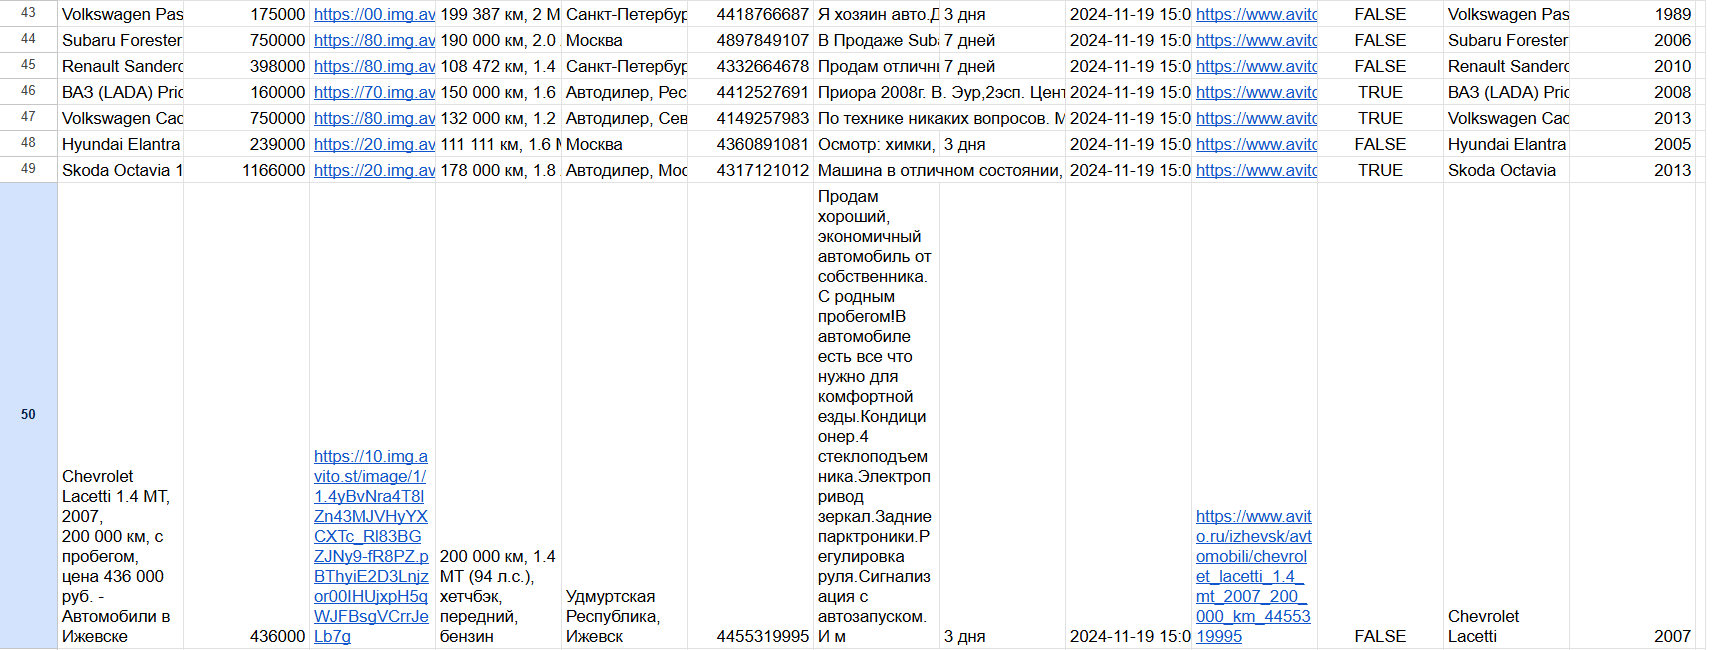

In [60]:
# Отображение изображения
display(Image(filename='Авито_1_2.png', width=1200, height=1000))

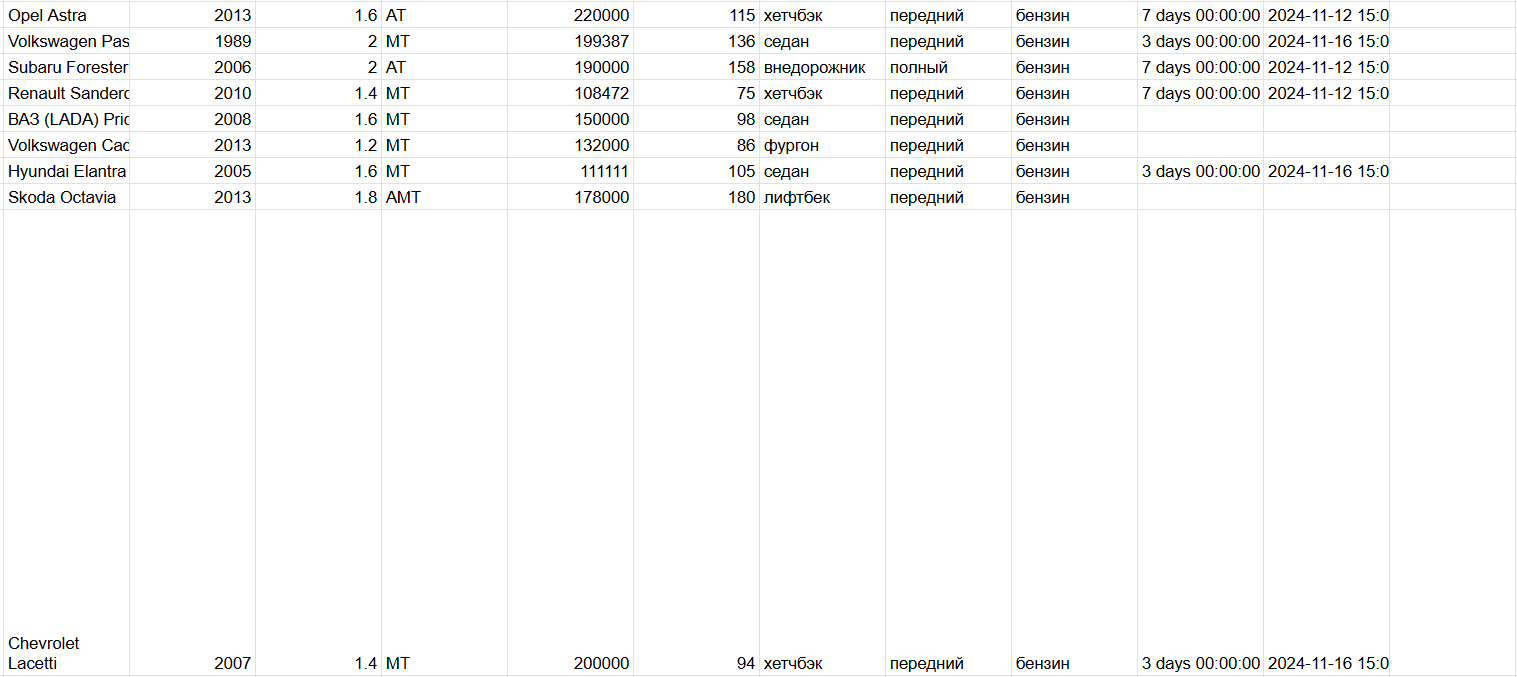

In [2]:
# Отображение изображения
display(Image(filename='Авито_1_3.png', width=1200, height=1000))